In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision.datasets
import torchvision.transforms

In [2]:
import time

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mnist_train = torchvision.datasets.MNIST(".", train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(".", train=False, download=True, transform=torchvision.transforms.ToTensor())

In [20]:
batch_size = 128
train_data = DataLoader(mnist_train, batch_size=batch_size, num_workers=4)
test_data = DataLoader(mnist_test, batch_size=batch_size)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
class Digits(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        self.loss = nn.CrossEntropyLoss()
        
    # image => logit
    def forward(self, x):
        y = self.layers(x)
        return y
    
    # image => prediction, probability
    @torch.no_grad()
    def predict(self, x):
        y = self.forward(x)
        p = F.softmax(y, dim=-1)
        pv, pi = torch.max(p, dim=-1)
        return pi, pv

In [13]:
def train(dataloader, model, optimizer):
    losses = []
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model.forward(x)
        loss = model.loss(pred, y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

In [14]:
@torch.no_grad()
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        test_loss += model.loss(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test: accuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}")
    return test_loss

In [15]:
def trainloop(model, epochs=5, optimizer=torch.optim.AdamW, **optargs):
    optimizer = optimizer(model.parameters(), **optargs)
    losses = []
    start = time.time()
    for t in range(epochs):
        epoch_loss = train(train_data, model, optimizer)
        losses += epoch_loss
    print(f"Train: {epochs} epochs took {time.time()-start:.2f} sec, last loss: {losses[-1]:>8f}")
    test(test_data, model)
    return losses

Digits(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
  (loss): CrossEntropyLoss()
)
Train: 30 epochs took 27.51 sec, last loss: 0.000054
Test: accuracy: 98.4%, avg loss: 0.094772


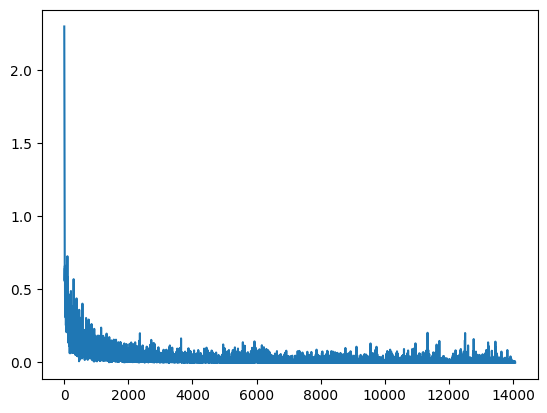

In [19]:
torch.manual_seed(42)
m = Digits().to(device)
print(m)
plt.plot(trainloop(m, epochs=30, weight_decay=0.01)) # note: this can get 0.2% higher if we use ReduceLROnPlateau scheduler but we'll aboid that for now